In [3]:
import json
import itertools
from sklearn import preprocessing
from sklearn.externals import joblib
import numpy as np
import pandas as pd
from datetime import datetime as dt
#Visualisation
#import matplotlib
import matplotlib.pyplot as plt
#%matplotlib inline
%matplotlib notebook
# from pylab import rcParams
# from matplotlib import gridspec
# import seaborn as sns
# from ggplot import *
# import plotly.plotly as py
# #Formatted Print 
# from IPython.display import Markdown, display

#NILMTK
from nilmtk import DataSet
from nilmtk.utils import print_dict
from nilmtk.datastore import HDFDataStore
from nilmtk.electric import align_two_meters



allowed_key_names = ['fridge','microwave','dish_washer','kettle','washing_machine']
WINDOW_PER_BUILDING = {
    1: ("2013-04-12", "2014-12-15"),
    2: ("2013-05-22", "2013-10-03 06:16:00"),
    3: ("2013-02-27", "2013-03-27 06:15:05"),
    4: ("2013-03-09", "2013-04-24 06:15:14"),
    5: ("2014-06-29", "2014-09-01")
}

/usr/local/anaconda/5.0.1-Python3.6-gcc5/envs/tensorflow-1.4-py3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/anaconda/5.0.1-Python3.6-gcc5/envs/tensorflow-1.4-py3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [23]:

from  tensorflow.python.keras.models import Model
from  tensorflow.python.keras.layers import Input, LSTM, Dense
from  tensorflow.python.keras.optimizers import Adam

latent_dim = 50 # LSTM hidden units
dropout = .20 

# Define an input series and encode it with an LSTM. 
encoder_inputs = Input(shape=(None, 1)) 
encoder = LSTM(latent_dim, dropout=dropout, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_inputs = Input(shape=(None, 1)) 

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, dropout=dropout, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

decoder_dense = Dense(1) # 1 continuous output at each timestep
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

/usr/local/anaconda/5.0.1-Python3.6-gcc5/envs/tensorflow-1.4-py3.6/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:766: DeprecationWarning: builtin type EagerTensor has no __module__ attribute
  EagerTensor = c_api.TFE_Py_InitEagerTensor(_EagerTensorBase)
/usr/local/anaconda/5.0.1-Python3.6-gcc5/envs/tensorflow-1.4-py3.6/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/usr/local/anaconda/5.0.1-Python3.6-gcc5/envs/tensorflow-1.4-py3.6/lib/python3.6/site-packages/tensorflow/python/keras/_impl/keras/backend.py:4046: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/osal10/.keras/keras.json' mode='r' encoding='UTF-8'>
  _config = json.load(open(_config_path))
/usr/local/anaconda/5.0.1-Python3.6-gcc5/envs/tensorflow-1.4-py3.6/lib/python3.6/site-packages/tensorflow/python

In [24]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, 1)       0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, None, 1)       0                                            
____________________________________________________________________________________________________
lstm_1 (LSTM)                    [(None, 50), (None, 5 10400       input_1[0][0]                    
____________________________________________________________________________________________________
lstm_2 (LSTM)                    [(None, None, 50), (N 10400       input_2[0][0]                    
                                                                   lstm_1[0][1]            

In [70]:
def get_data (key_name, start_date, end_date):

    
    sp =6
    # =======  Open configuration file  ===============
    appliances = json.load(open("../conf/apps.json",'r'))
    
    nilmtk_key= appliances[key_name]['key']
    
    v = appliances[key_name]
    data_path='/projects/da33/ozeidi/Project/data/UKDALE/ukdale.h5'
    #training_set = DataSet(data_path)
    validation_set = DataSet(data_path)

    #disag_filename =  '{}/{}_disag-out_{}epochs.h5'.format(save_path,nilmtk_key,end_e) # The filename of the resulting datastore
    #output = DataSet(disag_filename)

    val_builidng = v['validation_buildings'][0]


    validation_set.set_window(start=start_date,end=end_date)
    # This makes a list of references to the NILMTK main meters and submeter
    # no data is generated from them at this point
    mainchunk = validation_set.buildings[val_builidng].elec.mains().power_series_all_data(sample_period=sp)
    meterchunk = validation_set.buildings[val_builidng].elec.submeters()[nilmtk_key].power_series_all_data(sample_period=sp)

    mainchunk.fillna(0, inplace=True)
    meterchunk.fillna(0, inplace=True)
    ix = mainchunk.index.intersection(meterchunk.index)
    mainchunk = np.array(mainchunk[ix])
    meterchunk = np.array(meterchunk[ix])

    mainchunk = np.reshape(mainchunk, (mainchunk.shape[0],1,1))
    meterchunk = np.reshape(meterchunk, (meterchunk.shape[0],1,1))
    return mainchunk, meterchunk


In [71]:
def transform_series_encode(input_data):
    mean = np.mean(input_data)
    sd = np.std(input_data)
    input_data = (input_data -mean)/sd
    return input_data, mean,sd


def transform_series_decode(input_data, mean,sd):
    input_data = (input_data -mean)/sd
    return input_data

In [72]:
ma,me = get_data('kettle',"2013-05-22", "2013-09-03 06:16:00")


/home/osal10/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: ResourceWarning: unclosed file <_io.TextIOWrapper name='../conf/apps.json' mode='r' encoding='UTF-8'>
  


In [ ]:
np.nan_to_num()

In [48]:
2**11

2048

In [63]:

first_n_samples = 20000
batch_size = 2**11
epochs = 100

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = ma[:first_n_samples]
encoder_input_data, encode_series_mean,encode_series_sd = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = me[:first_n_samples]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean, encode_series_sd)

# lagged target series for teacher forcing
decoder_input_data = np.zeros(decoder_target_data.shape)
decoder_input_data[:,1:,0] = decoder_target_data[:,:-1,0]
decoder_input_data[:,0,0] = encoder_input_data[:,-1,0]

model.compile(optimizer='Adam', loss='mse')


/usr/local/anaconda/5.0.1-Python3.6-gcc5/envs/tensorflow-1.4-py3.6/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/usr/local/anaconda/5.0.1-Python3.6-gcc5/envs/tensorflow-1.4-py3.6/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


In [64]:
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_split=0.2)

/usr/local/anaconda/5.0.1-Python3.6-gcc5/envs/tensorflow-1.4-py3.6/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/usr/local/anaconda/5.0.1-Python3.6-gcc5/envs/tensorflow-1.4-py3.6/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


Train on 16000 samples, validate on 4000 samples
Epoch 1/100
16000/16000 [==============================] - 1s - loss: 0.1075 - val_loss: 0.0026
Epoch 2/100
16000/16000 [==============================] - 0s - loss: 0.0706 - val_loss: 0.0026
Epoch 3/100
16000/16000 [==============================] - 0s - loss: 0.0622 - val_loss: 0.0019
Epoch 4/100
16000/16000 [==============================] - 0s - loss: 0.0618 - val_loss: 1.4208e-04
Epoch 5/100
16000/16000 [==============================] - 0s - loss: 0.0536 - val_loss: 1.5110e-04
Epoch 6/100
16000/16000 [==============================] - 0s - loss: 0.0495 - val_loss: 8.3032e-05
Epoch 7/100
16000/16000 [==============================] - 0s - loss: 0.0484 - val_loss: 1.4701e-04
Epoch 8/100
16000/16000 [==============================] - 0s - loss: 0.0526 - val_loss: 5.1864e-04
Epoch 9/100
16000/16000 [==============================] - 0s - loss: 0.0464 - val_loss: 3.7928e-05
Epoch 10/100
16000/16000 [==============================] - 0s 

16000/16000 [==============================] - 0s - loss: 0.0436 - val_loss: 4.2080e-05
Epoch 83/100
16000/16000 [==============================] - 0s - loss: 0.0441 - val_loss: 5.0772e-05
Epoch 84/100
16000/16000 [==============================] - 0s - loss: 0.0457 - val_loss: 8.6136e-05
Epoch 85/100
16000/16000 [==============================] - 0s - loss: 0.0464 - val_loss: 8.0923e-05
Epoch 86/100
16000/16000 [==============================] - 0s - loss: 0.0452 - val_loss: 4.6664e-05
Epoch 87/100
16000/16000 [==============================] - 0s - loss: 0.0446 - val_loss: 8.2183e-04
Epoch 88/100
16000/16000 [==============================] - 0s - loss: 0.0485 - val_loss: 2.3717e-04
Epoch 89/100
16000/16000 [==============================] - 0s - loss: 0.0459 - val_loss: 7.8191e-05
Epoch 90/100
16000/16000 [==============================] - 0s - loss: 0.0461 - val_loss: 5.5182e-05
Epoch 91/100
16000/16000 [==============================] - 0s - loss: 0.0430 - val_loss: 2.4551e-04
Epo

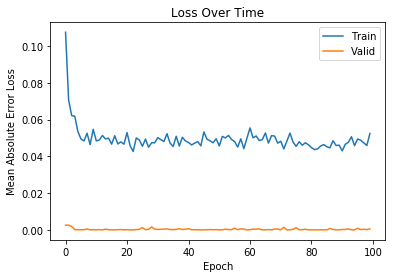

In [65]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])


In [67]:
# from our previous model - mapping encoder sequence to state vectors
encoder_model = Model(encoder_inputs, encoder_states)

# A modified version of the decoding stage that takes in predicted target inputs
# and encoded state vectors, returning predicted target outputs and decoder state vectors.
# We need to hang onto these state vectors to run the next step of the inference loop.
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

def decode_sequence(input_seq):
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, 1))
    
    # Populate the first target sequence with end of encoding series pageviews
    target_seq[0, 0, 0] = input_seq[0, -1, 0]

    # Sampling loop for a batch of sequences - we will fill decoded_seq with predictions
    # (to simplify, here we assume a batch of size 1).

    decoded_seq = np.zeros((1,pred_steps,1))
    
    for i in range(pred_steps):
        
        output, h, c = decoder_model.predict([target_seq] + states_value)
        
        decoded_seq[0,i,0] = output[0,0,0]

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, 1))
        target_seq[0, 0, 0] = output[0,0,0]

        # Update states
        states_value = [h, c]

    return decoded_seq

/usr/local/anaconda/5.0.1-Python3.6-gcc5/envs/tensorflow-1.4-py3.6/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/usr/local/anaconda/5.0.1-Python3.6-gcc5/envs/tensorflow-1.4-py3.6/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


In [73]:
ma_test,me_test = get_data('kettle',"2013-09-04", "2013-10-03 06:16:00")
encoder_input_data = ma_test
encoder_input_data, encode_series_mean ,encode_series_sd = transform_series_encode(encoder_input_data)

decoder_target_data = me_test
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean,encode_series_sd)

/home/osal10/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: ResourceWarning: unclosed file <_io.TextIOWrapper name='../conf/apps.json' mode='r' encoding='UTF-8'>
  


In [77]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=50):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    pred_series = decode_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

In [78]:
predict_and_plot(encoder_input_data, decoder_target_data, 100)


InvalidArgumentError: You must feed a value for placeholder tensor 'lstm/keras_learning_phase' with dtype bool
	 [[Node: lstm/keras_learning_phase = Placeholder[dtype=DT_BOOL, shape=<unknown>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: lstm/keras_learning_phase/_1137 = _HostRecv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_58_lstm/keras_learning_phase", tensor_type=DT_BOOL, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'lstm/keras_learning_phase', defined at:
  File "/usr/local/anaconda/5.0.1-Python3.6-gcc5/envs/tensorflow-1.4-py3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/anaconda/5.0.1-Python3.6-gcc5/envs/tensorflow-1.4-py3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/osal10/.local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/osal10/.local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/osal10/.local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/osal10/.local/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/local/anaconda/5.0.1-Python3.6-gcc5/envs/tensorflow-1.4-py3.6/lib/python3.6/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/usr/local/anaconda/5.0.1-Python3.6-gcc5/envs/tensorflow-1.4-py3.6/lib/python3.6/asyncio/base_events.py", line 1431, in _run_once
    handle._run()
  File "/usr/local/anaconda/5.0.1-Python3.6-gcc5/envs/tensorflow-1.4-py3.6/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/osal10/.local/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "/home/osal10/.local/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/osal10/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/osal10/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/osal10/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/osal10/.local/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/osal10/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/osal10/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/osal10/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/osal10/.local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/osal10/.local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/osal10/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/osal10/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/osal10/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2901, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/osal10/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-23-b38dbc09c924>", line 12, in <module>
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
  File "/usr/local/anaconda/5.0.1-Python3.6-gcc5/envs/tensorflow-1.4-py3.6/lib/python3.6/site-packages/tensorflow/python/keras/_impl/keras/layers/recurrent.py", line 293, in __call__
    return super(Recurrent, self).__call__(inputs, **kwargs)
  File "/usr/local/anaconda/5.0.1-Python3.6-gcc5/envs/tensorflow-1.4-py3.6/lib/python3.6/site-packages/tensorflow/python/keras/_impl/keras/engine/topology.py", line 252, in __call__
    output = super(Layer, self).__call__(inputs, **kwargs)
  File "/usr/local/anaconda/5.0.1-Python3.6-gcc5/envs/tensorflow-1.4-py3.6/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 575, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "/usr/local/anaconda/5.0.1-Python3.6-gcc5/envs/tensorflow-1.4-py3.6/lib/python3.6/site-packages/tensorflow/python/keras/_impl/keras/layers/recurrent.py", line 363, in call
    preprocessed_input = self.preprocess_input(inputs, training=None)
  File "/usr/local/anaconda/5.0.1-Python3.6-gcc5/envs/tensorflow-1.4-py3.6/lib/python3.6/site-packages/tensorflow/python/keras/_impl/keras/layers/recurrent.py", line 1129, in preprocess_input
    training=training)
  File "/usr/local/anaconda/5.0.1-Python3.6-gcc5/envs/tensorflow-1.4-py3.6/lib/python3.6/site-packages/tensorflow/python/keras/_impl/keras/layers/recurrent.py", line 73, in _time_distributed_dense
    x = K.in_train_phase(x * expanded_dropout_matrix, x, training=training)
  File "/usr/local/anaconda/5.0.1-Python3.6-gcc5/envs/tensorflow-1.4-py3.6/lib/python3.6/site-packages/tensorflow/python/keras/_impl/keras/backend.py", line 2820, in in_train_phase
    training = learning_phase()
  File "/usr/local/anaconda/5.0.1-Python3.6-gcc5/envs/tensorflow-1.4-py3.6/lib/python3.6/site-packages/tensorflow/python/keras/_impl/keras/backend.py", line 325, in learning_phase
    phase = array_ops.placeholder(dtype='bool', name='keras_learning_phase')
  File "/usr/local/anaconda/5.0.1-Python3.6-gcc5/envs/tensorflow-1.4-py3.6/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1599, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "/usr/local/anaconda/5.0.1-Python3.6-gcc5/envs/tensorflow-1.4-py3.6/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3091, in _placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/usr/local/anaconda/5.0.1-Python3.6-gcc5/envs/tensorflow-1.4-py3.6/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/anaconda/5.0.1-Python3.6-gcc5/envs/tensorflow-1.4-py3.6/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/usr/local/anaconda/5.0.1-Python3.6-gcc5/envs/tensorflow-1.4-py3.6/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'lstm/keras_learning_phase' with dtype bool
	 [[Node: lstm/keras_learning_phase = Placeholder[dtype=DT_BOOL, shape=<unknown>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: lstm/keras_learning_phase/_1137 = _HostRecv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_58_lstm/keras_learning_phase", tensor_type=DT_BOOL, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [81]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from  tensorflow.python.keras.utils import to_categorical
from  tensorflow.python.keras.models import Model
from  tensorflow.python.keras.layers import Input, LSTM , Dense

# generate a sequence of random integers
def generate_sequence(length, n_unique):
	return [randint(1, n_unique-1) for _ in range(length)]

# prepare data for the LSTM
def get_dataset(n_in, n_out, cardinality, n_samples):
	X1, X2, y = list(), list(), list()
	for _ in range(n_samples):
		# generate source sequence
		source = generate_sequence(n_in, cardinality)
		# define padded target sequence
		target = source[:n_out]
		target.reverse()
		# create padded input target sequence
		target_in = [0] + target[:-1]
		# encode
		src_encoded = source
		tar_encoded = target
		tar2_encoded = target_in
		# store
		X1.append(src_encoded)
		X2.append(tar2_encoded)
		y.append(tar_encoded)
	return array(X1), array(X2), array(y)

# returns train, inference_encoder and inference_decoder models
def define_models(n_input, n_output, n_units):
	# define training encoder
	encoder_inputs = Input(shape=(None, n_input))
	encoder = LSTM(n_units, return_state=True)
	encoder_outputs, state_h, state_c = encoder(encoder_inputs)
	encoder_states = [state_h, state_c]
	# define training decoder
	decoder_inputs = Input(shape=(None, n_output))
	decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
	decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
	decoder_dense = Dense(n_output, activation='linear')
	decoder_outputs = decoder_dense(decoder_outputs)
	model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
	# define inference encoder
	encoder_model = Model(encoder_inputs, encoder_states)
	# define inference decoder
	decoder_state_input_h = Input(shape=(n_units,))
	decoder_state_input_c = Input(shape=(n_units,))
	decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
	decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
	decoder_states = [state_h, state_c]
	decoder_outputs = decoder_dense(decoder_outputs)
	decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
	# return all models
	return model, encoder_model, decoder_model

# generate target given source sequence
def predict_sequence(infenc, infdec, source, n_steps, cardinality):
	# encode
	state = infenc.predict(source)
	# start of sequence input
	target_seq = array([0.0 for _ in range(cardinality)]).reshape(1, 1, cardinality)
	# collect predictions
	output = list()
	for t in range(n_steps):
		# predict next char
		yhat, h, c = infdec.predict([target_seq] + state)
		# store prediction
		output.append(yhat[0,0,:])
		# update state
		state = [h, c]
		# update target sequence
		target_seq = yhat
	return array(output)

# decode a one hot encoded string
def one_hot_decode(encoded_seq):
	return [argmax(vector) for vector in encoded_seq]

# configure problem
n_features = 50 + 1
n_steps_in = 6
n_steps_out = 3
# define model
train, infenc, infdec = define_models(n_features, n_features, 128)
train.compile(optimizer='adam', loss='mse', metrics=['acc'])
# generate training dataset
X1, X2, y = get_dataset(n_steps_in, n_steps_out, n_features, 100000)
print(X1.shape,X2.shape,y.shape)
# train model
train.fit([X1, X2], y, epochs=1)
# evaluate LSTM
total, correct = 100, 0
for _ in range(total):
	X1, X2, y = get_dataset(n_steps_in, n_steps_out, n_features, 1)
	target = predict_sequence(infenc, infdec, X1, n_steps_out, n_features)
	if array_equal(one_hot_decode(y[0]), one_hot_decode(target)):
		correct += 1
print('Accuracy: %.2f%%' % (float(correct)/float(total)*100.0))
# spot check some examples
for _ in range(10):
	X1, X2, y = get_dataset(n_steps_in, n_steps_out, n_features, 1)
	target = predict_sequence(infenc, infdec, X1, n_steps_out, n_features)
	print('X=%s y=%s, yhat=%s' % (one_hot_decode(X1[0]), one_hot_decode(y[0]), one_hot_decode(target)))

/usr/local/anaconda/5.0.1-Python3.6-gcc5/envs/tensorflow-1.4-py3.6/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/usr/local/anaconda/5.0.1-Python3.6-gcc5/envs/tensorflow-1.4-py3.6/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


(100000, 6) (100000, 3) (100000, 3)


ValueError: Error when checking input: expected input_15 to have 3 dimensions, but got array with shape (100000, 6)